# Main Project 2 - U-Net을 이용한 이미지 세그멘테이션

In [2]:
import os
import random, math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, utils, Input, Model

import warnings
warnings.filterwarnings(action='ignore')

### (1) 실습환경 준비

In [ ]:
%pip install datasets
%pip install huggingface_hub

In [3]:
import datasets
from datasets import load_dataset

train_dataset, val_dataset = load_dataset("nateraw/pascal-voc-2012", split=['train', 'val'])
dataset = pd.DataFrame(train_dataset)
dataset

,image,mask
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...
1459,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1460,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1461,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1462,<PIL.JpegImagePlugin.JpegImageFile image mode=...,<PIL.PngImagePlugin.PngImageFile image mode=RG...


### (2) 데이터 전처리

- 데이터 크기 조절

In [4]:
from PIL import Image

dataset['reimage'] = None
dataset['remask'] = None

# (512, 512)로 크기 조절
for i in range(len(dataset)):
    dataset['reimage'][i] = np.array(dataset['image'][i].resize((512, 512)))
    dataset['remask'][i] = np.array(dataset['mask'][i].resize((512, 512)))

# 결측치 확인
dataset.isnull().sum()

image      0
mask       0
reimage    0
remask     0
dtype: int64

In [5]:
# data check
print(np.shape(dataset['reimage'][0]))
print(np.shape(dataset['remask'][0]))

(512, 512, 3)
(512, 512, 3)


- label image 생성

In [7]:
# colormap 만들기
def make_colormap(num=256):
    colormap = np.zeros((num, 3), dtype=int)
    ind = np.arange(num, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap

In [8]:
cmap = list(make_colormap())
palette = [value for color in cmap for value in color]
print(cmap)
print(palette)

[array([0, 0, 0]), array([128,   0,   0]), array([  0, 128,   0]), array([128, 128,   0]), array([  0,   0, 128]), array([128,   0, 128]), array([  0, 128, 128]), array([128, 128, 128]), array([64,  0,  0]), array([192,   0,   0]), array([ 64, 128,   0]), array([192, 128,   0]), array([ 64,   0, 128]), array([192,   0, 128]), array([ 64, 128, 128]), array([192, 128, 128]), array([ 0, 64,  0]), array([128,  64,   0]), array([  0, 192,   0]), array([128, 192,   0]), array([  0,  64, 128]), array([128,  64, 128]), array([  0, 192, 128]), array([128, 192, 128]), array([64, 64,  0]), array([192,  64,   0]), array([ 64, 192,   0]), array([192, 192,   0]), array([ 64,  64, 128]), array([192,  64, 128]), array([ 64, 192, 128]), array([192, 192, 128]), array([ 0,  0, 64]), array([128,   0,  64]), array([  0, 128,  64]), array([128, 128,  64]), array([  0,   0, 192]), array([128,   0, 192]), array([  0, 128, 192]), array([128, 128, 192]), array([64,  0, 64]), array([192,   0,  64]), array([ 64, 

In [ ]:
dataset['label'] = None

with tf.device('/GPU:0'):
    for i in range(len(dataset)):
        label = np.zeros((512, 512), dtype=int)

        for index, val_col in enumerate(cmap):
            label[np.where(np.all(dataset['remask'][i] == val_col, axis=-1))] = index

        dataset['label'][i] = label

In [12]:
dataset['label'][1]

In [37]:
# train, test set split
train_size = math.floor(len(dataset) * 0.7)
val_size = math.floor(len(dataset) * 0.9)

train_image = np.array(list(dataset['reimage'][:train_size]))
train_label = np.array(list(dataset['remask'][:train_size]))

val_image = np.array(list(dataset['reimage'][train_size:val_size]))
val_label = np.array(list(dataset['remask'][train_size:val_size]))

test_image = np.array(list(dataset['reimage'][val_size:]))
test_label = np.array(list(dataset['remask'][val_size:]))

In [38]:
print(np.shape(list(dataset['reimage'])))
print(np.shape(train_image))
print(type(train_image))


(1464, 512, 512, 3)
(1024, 512, 512, 3)
<class 'numpy.ndarray'>


### (3) U-Net 구현

- Convolution block

In [7]:
def conv_block(inputs, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(n_filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

- Encoder block

In [8]:
def encode_block(inputs, n_filters):
    x = conv_block(inputs, n_filters)
    e = layers.MaxPooling2D((2, 2))(x)

    return x, e

- Decoder block

In [45]:
def decode_block(inputs, skip, n_filters):
    d = layers.Conv2DTranspose(n_filters, (2, 2), strides=2, padding='same')(inputs)
    x = layers.Concatenate()([d, skip])
    x = conv_block(x, n_filters)

    return x

- U-Net

In [46]:
def UNET(n_classes):
    inputs = Input(shape=(512, 512, 3))

    e1, x = encode_block(inputs, 64)
    e2, x = encode_block(x, 128)
    e3, x = encode_block(x, 256)
    e4, x = encode_block(x, 512)

    x = conv_block(x, 1024)

    x = decode_block(x, e4, 512)
    x = decode_block(x, e3, 256)
    x = decode_block(x, e2, 128)
    x = decode_block(x, e1, 64)

    if n_classes == 1:
        x = layers.Conv2D(n_classes, 1, padding='same', activation='sigmoid')(x)
    else:
        x = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x)

    return Model(inputs, x, name='U-Net')

In [47]:
with tf.device('/GPU:0'):
    model = UNET(3)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=METRICS
    )

    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_28 (BatchN  (None, 512, 512, 64  256        ['conv2d_30[0][0]']              
 ormalization)                  )                                                             

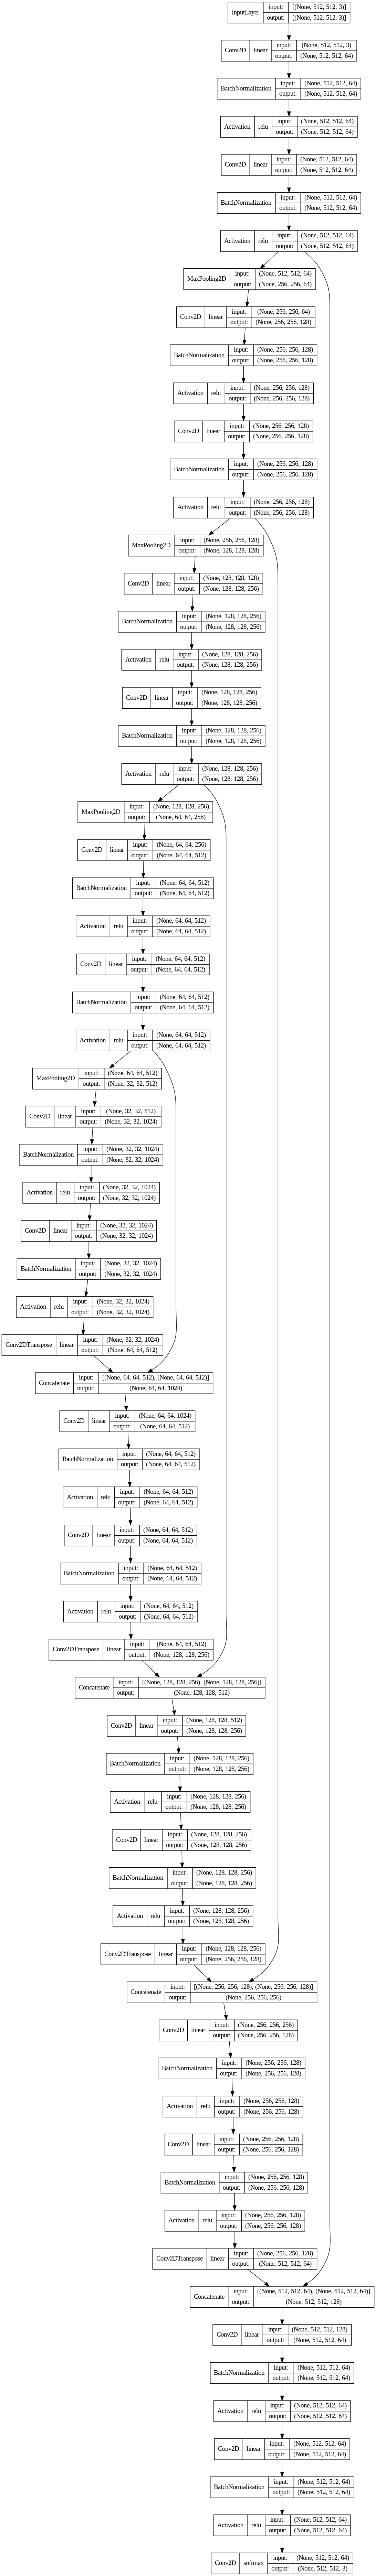

In [48]:
utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

### (4) 모델 학습

In [49]:
BATCH_SIZE = 16
EPOCHS = 20

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_image,
        train_label,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(val_image, val_label)
    )

Epoch 1/20


ValueError: ignored